# PRABU - Incremental Learning untuk Prediksi Risiko Kredit Lintas Sektor

Notebook ini mendemonstrasikan penggunaan model Machine Learning dengan kemampuan pembelajaran inkremental untuk memprediksi risiko kredit. Model ini dirancang untuk dapat belajar dari data historis dan data dari berbagai sektor industri.

## 1. Setup dan Import Library

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import importlib
import joblib # Added for potentially reloading label encoder

# Tambahkan path ke direktori root proyek jika perlu (misalnya, jika notebook ada di subfolder)
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from PrabuModule import incremental_model_trainer
from PrabuModule import ml_credit_risk_predictor

# Reload modul untuk memastikan perubahan terbaru terbaca (berguna saat development)
importlib.reload(incremental_model_trainer)
importlib.reload(ml_credit_risk_predictor)

DATASET_DIR = os.path.join(module_path, 'PrabuModule', 'datasets')

# Hapus model dan preprocessor lama untuk demo yang bersih setiap kali dijalankan
print("Menghapus model, preprocessor, dan file kelas lama (jika ada) untuk demo...")
if os.path.exists(incremental_model_trainer.MODEL_PATH): 
    os.remove(incremental_model_trainer.MODEL_PATH)
if os.path.exists(incremental_model_trainer.PREPROCESSOR_PATH): 
    os.remove(incremental_model_trainer.PREPROCESSOR_PATH)
if os.path.exists(incremental_model_trainer.CLASSES_PATH): 
    os.remove(incremental_model_trainer.CLASSES_PATH)
print("File-file lama berhasil dihapus.")

Model CatBoost dimuat dari /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/incremental_risk_model.cbm
Preprocessor numerik dimuat dari /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/preprocessor.joblib
LabelEncoder dimuat dari /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/label_encoder.joblib
Model CatBoost dimuat dari /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/incremental_risk_model.cbm
Preprocessor numerik dimuat dari /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/preprocessor.joblib
LabelEncoder dimuat dari /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/label_encoder.joblib
Menghapus model, preprocessor, dan file kelas lama (jika ada) untuk demo...
File-file lama berhasil dihapus.


## 2. Memuat Semua Dataset Sintetis
Data dari berbagai sektor dan perusahaan dimuat untuk simulasi.

In [2]:
all_data = incremental_model_trainer.load_all_datasets(dataset_folder=DATASET_DIR)
if not all_data.empty:
    print(f"Total data yang dimuat dari semua file CSV: {len(all_data)} baris")
    print(f"Kolom yang ada: {all_data.columns.tolist()}")
    print("\nContoh beberapa baris data:")
    display(all_data.head())
    print("\nDistribusi Kategori Risiko (TARGET_COLUMN):")
    display(all_data[incremental_model_trainer.TARGET_COLUMN].value_counts())
    print("\nDistribusi Sektor:")
    display(all_data['Sektor'].value_counts())
else:
    print("Tidak ada data yang dimuat. Pastikan file CSV ada di direktori yang benar.")

Total data yang dimuat dari semua file CSV: 25 baris
Kolom yang ada: ['UniqueID', 'NamaPerusahaan', 'Sektor', 'PeriodeTahun', 'PeriodeKuartal', 'CurrentRatio', 'DebtToEquityRatio', 'NetProfitMargin', 'ROA', 'ROE', 'InterestCoverageRatio', 'SalesGrowth', 'AssetTurnover', 'QuickRatio', 'OperatingMargin', 'Mining_ProductionVolume', 'Mining_ReserveLife', 'Mining_CashCostPerUnit', 'Mining_CommodityPriceExposure', 'Mining_CapexIntensity', 'Construction_OrderBookValue', 'Construction_ProjectCompletionRate', 'Construction_BacklogToRevenueRatio', 'Construction_DebtServiceCoverageRatio_Project', 'Construction_SubcontractorRiskExposure', 'Agro_PlantedArea', 'Agro_YieldPerHectare', 'Agro_CommodityPriceVolatility', 'Agro_AgeOfPlantation', 'Agro_StorageCapacityUtilization', 'Manufacturing_ProductionCapacity', 'Manufacturing_InventoryTurnoverDays_FG', 'Manufacturing_OrderBacklog', 'Manufacturing_RDExpenditureAsPercentageOfSales', 'Manufacturing_SupplierConcentrationRisk', 'Logistics_FleetSize', 'Logi

,UniqueID,NamaPerusahaan,Sektor,PeriodeTahun,PeriodeKuartal,CurrentRatio,DebtToEquityRatio,NetProfitMargin,ROA,ROE,...,Manufacturing_OrderBacklog,Manufacturing_RDExpenditureAsPercentageOfSales,Manufacturing_SupplierConcentrationRisk,Logistics_FleetSize,Logistics_FleetUtilizationRate,Logistics_AverageFleetAge,Logistics_MaintenanceCostRatio,Logistics_ClientConcentrationRisk,CreditRiskScore,RiskCategory
0,PT_Tambang_Jaya_Pertambangan_2019,PT Tambang Jaya,Pertambangan,2019,Q4,2.510981,2.715494,0.144501,0.078424,0.262419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.138317,Medium
1,PT_Tambang_Jaya_Pertambangan_2020,PT Tambang Jaya,Pertambangan,2020,Q4,1.500654,2.420897,0.018727,0.012041,0.028453,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.987115,Medium
2,PT_Tambang_Jaya_Pertambangan_2021,PT Tambang Jaya,Pertambangan,2021,Q4,3.007081,0.624585,0.178642,0.061843,0.289653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.999800,Low
3,PT_Tambang_Jaya_Pertambangan_2022,PT Tambang Jaya,Pertambangan,2022,Q4,1.901491,0.818672,0.166600,0.067136,0.412089,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.727764,Low
4,PT_Tambang_Jaya_Pertambangan_2023,PT Tambang Jaya,Pertambangan,2023,Q4,1.255756,3.265307,-0.005088,0.002334,-0.007216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.327027,High



Distribusi Kategori Risiko (TARGET_COLUMN):


RiskCategory
Low       10
Medium     9
High       6
Name: count, dtype: int64


Distribusi Sektor:


Sektor
Pertambangan             5
Konstruksi               5
Logistik Alat Berat      5
Manufaktur Alat Berat    5
Agro                     5
Name: count, dtype: int64

## 3. Pelatihan Model Awal
Model dilatih pada sebagian data awal. Misalnya, data dari sektor 'Pertambangan' dan 'Konstruksi' hingga tahun 2021.

In [3]:
current_model = None
current_preprocessor = None
current_label_encoder = None # Initialize label encoder

if not all_data.empty:
    # Pilih data untuk pelatihan awal
    # Misal, ambil data dari 2 sektor pertama dan hingga tahun 2021
    initial_sectors = ['Pertambangan', 'Konstruksi']
    df_initial_train = all_data[
        (all_data['Sektor'].isin(initial_sectors)) &
        (all_data['PeriodeTahun'] <= 2021)
    ].copy()

    if not df_initial_train.empty:
        print(f"Jumlah data untuk pelatihan awal: {len(df_initial_train)} baris")
        print(f"Sektor dalam data awal: {df_initial_train['Sektor'].unique().tolist()}")
        print(f"Tahun dalam data awal: {df_initial_train['PeriodeTahun'].unique().tolist()}")
        
        # train_initial_model now returns model, preprocessor, and label_encoder
        current_model, current_preprocessor, current_label_encoder = incremental_model_trainer.train_initial_model(
            df_initial_train, 
            force_retrain_preprocessor=True,
            force_retrain_labelencoder=True # Force retrain for the first run
        )
        if current_model and current_preprocessor and current_label_encoder:
            print("\nModel awal dan komponen terkait berhasil dilatih/dibuat.")
        else:
            print("\nGagal melatih model awal atau membuat komponen terkait.")
    else:
        print("Tidak ada data yang memenuhi kriteria untuk pelatihan awal.")
else:
    print("Tidak ada data untuk diproses.")

Jumlah data untuk pelatihan awal: 6 baris
Sektor dalam data awal: ['Pertambangan', 'Konstruksi']
Tahun dalam data awal: [2019, 2020, 2021]
LabelEncoder dan file kelas lama dihapus untuk pelatihan ulang.
Membuat LabelEncoder baru...
LabelEncoder baru disimpan di /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/label_encoder.joblib
Kelas target (string) disimpan: ['High' 'Low' 'Medium']
Membuat preprocessor numerik baru...
Melatih preprocessor numerik pada kolom: ['CurrentRatio', 'DebtToEquityRatio', 'NetProfitMargin', 'ROA', 'ROE', 'InterestCoverageRatio', 'SalesGrowth', 'AssetTurnover', 'QuickRatio', 'OperatingMargin', 'Manufacturing_ProductionCapacity', 'Agro_PlantedArea', 'Logistics_MaintenanceCostRatio', 'Logistics_FleetSize', 'Construction_BacklogToRevenueRatio', 'Manufacturing_RDExpenditureAsPercentageOfSales', 'Logistics_ClientConcentrationRisk', 'Logistics_AverageFleetAge', 'Mining_CommodityPriceExposure', 'Agro_YieldPerHectare', 'Agro_CommodityPriceVolatil

/Users/raihanpk/Documents/GitHub/astranauts/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/raihanpk/Documents/GitHub/astranauts/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/raihanpk/Documents/GitHub/astranauts/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


## 4. Pembelajaran Inkremental: Menambahkan Data dari Sektor Baru
Simulasikan kedatangan data dari sektor baru (misalnya, 'Agro') dan perbarui model.

In [4]:
if current_model and current_preprocessor and not all_data.empty:
    df_new_sector_data = all_data[
        (all_data['Sektor'] == 'Agro') &
        (all_data['PeriodeTahun'] <= 2021) # Ambil data historis awal sektor baru juga
    ].copy()

    if not df_new_sector_data.empty:
        print(f"\n--- Memperbarui model dengan data sektor baru (Agro) --- ({len(df_new_sector_data)} baris)")
        # Tambahan: Cek nilai unik di kolom target sebelum update
        print(f"Nilai unik di '{incremental_model_trainer.TARGET_COLUMN}' pada data Agro baru sebelum update:")
        print(df_new_sector_data[incremental_model_trainer.TARGET_COLUMN].value_counts())
        
        current_model = incremental_model_trainer.update_model_incrementally(
            df_new_sector_data, 
            existing_model_path=incremental_model_trainer.MODEL_PATH, # Pass model path
            preprocessor=current_preprocessor,
            label_encoder=current_label_encoder # Pass label encoder
        )
        if current_model:
            print("Model berhasil diperbarui dengan data sektor Agro.")
    else:
        print("\nTidak ada data untuk sektor Agro yang memenuhi kriteria.")
else:
    print("Model awal belum dilatih atau tidak ada data, langkah ini dilewati.")


--- Memperbarui model dengan data sektor baru (Agro) --- (3 baris)
Nilai unik di 'RiskCategory' pada data Agro baru sebelum update:
RiskCategory
Low    3
Name: count, dtype: int64
Peringatan: Data target baru hanya memiliki satu nilai unik setelah encoding.
Model tidak akan diperbarui dengan data ini untuk menghindari error CatBoost.
Mengembalikan model yang sudah ada dari: /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/incremental_risk_model.cbm
Model berhasil diperbarui dengan data sektor Agro.


## 5. Pembelajaran Inkremental: Menambahkan Data Historis Baru
Simulasikan kedatangan data historis baru (misalnya, tahun 2022 dan 2023) untuk sektor yang sudah ada.

In [5]:
if current_model and current_preprocessor and not all_data.empty:
    # Ambil data dari tahun 2022 dan 2023 untuk semua sektor yang sudah dikenal model
    # (Pertambangan, Konstruksi, Agro pada titik ini)
    known_sectors = ['Pertambangan', 'Konstruksi', 'Agro'] 
    df_new_historical_data = all_data[
        (all_data['Sektor'].isin(known_sectors)) &
        (all_data['PeriodeTahun'] > 2021) 
    ].copy()

    if not df_new_historical_data.empty:
        print(f"\n--- Memperbarui model dengan data historis baru (Tahun > 2021) --- ({len(df_new_historical_data)} baris)")
        print(f"Sektor dalam data historis baru: {df_new_historical_data['Sektor'].unique().tolist()}")
        print(f"Tahun dalam data historis baru: {df_new_historical_data['PeriodeTahun'].unique().tolist()}")
        current_model = incremental_model_trainer.update_model_incrementally(
            df_new_historical_data, 
            existing_model_path=incremental_model_trainer.MODEL_PATH,
            preprocessor=current_preprocessor,
            label_encoder=current_label_encoder
        )
        if current_model:
            print("Model berhasil diperbarui dengan data historis baru.")
    else:
        print("\nTidak ada data historis baru yang memenuhi kriteria.")
else:
    print("Model awal belum dilatih atau tidak ada data, langkah ini dilewati.")


--- Memperbarui model dengan data historis baru (Tahun > 2021) --- (6 baris)
Sektor dalam data historis baru: ['Pertambangan', 'Konstruksi', 'Agro']
Tahun dalam data historis baru: [2022, 2023]
Memuat model CatBoost dari /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/incremental_risk_model.cbm untuk pembaruan...
Memperbarui model CatBoost secara inkremental (melanjutkan pelatihan)...
Model CatBoost yang diperbarui disimpan di /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/incremental_risk_model.cbm
Laporan Klasifikasi pada Data Baru (setelah pembaruan):
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         2
         Low       1.00      1.00      1.00         3
      Medium       1.00      1.00      1.00         1

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

Model berh

## 6. Pembelajaran Inkremental: Menambahkan Sektor Lainnya
Tambahkan sisa sektor (Manufaktur Alat Berat, Logistik Alat Berat) untuk semua periode waktu.

In [6]:
if current_model and current_preprocessor and not all_data.empty:
    remaining_sectors = ['Manufaktur Alat Berat', 'Logistik Alat Berat']
    df_remaining_sector_data = all_data[all_data['Sektor'].isin(remaining_sectors)].copy()

    if not df_remaining_sector_data.empty:
        print(f"\n--- Memperbarui model dengan data sektor sisanya --- ({len(df_remaining_sector_data)} baris)")
        print(f"Sektor dalam data baru: {df_remaining_sector_data['Sektor'].unique().tolist()}")
        current_model = incremental_model_trainer.update_model_incrementally(
            df_remaining_sector_data, 
            existing_model_path=incremental_model_trainer.MODEL_PATH,
            preprocessor=current_preprocessor,
            label_encoder=current_label_encoder
        )
        if current_model:
            print("Model berhasil diperbarui dengan data sektor sisanya.")
    else:
        print("\nTidak ada data untuk sektor sisanya.")
else:
    print("Model awal belum dilatih atau tidak ada data, langkah ini dilewati.")


--- Memperbarui model dengan data sektor sisanya --- (10 baris)
Sektor dalam data baru: ['Logistik Alat Berat', 'Manufaktur Alat Berat']
Memuat model CatBoost dari /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/incremental_risk_model.cbm untuk pembaruan...
Memperbarui model CatBoost secara inkremental (melanjutkan pelatihan)...
Model CatBoost yang diperbarui disimpan di /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/incremental_risk_model.cbm
Laporan Klasifikasi pada Data Baru (setelah pembaruan):
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         2
         Low       1.00      1.00      1.00         3
      Medium       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Model berhasil diperbarui dengan data sektor sisanya.


## 7. Demonstrasi Prediksi
Lakukan prediksi pada beberapa sampel data menggunakan model yang sudah final (setelah semua pembaruan).

In [7]:
if not all_data.empty:
    # Reload model dan preprocessor terbaru dari file (untuk memastikan kita menggunakan versi yang disimpan)
    # ml_credit_risk_predictor._load_resources() # Panggil ini jika ingin paksa reload di modulnya
    # atau kita bisa memuatnya secara manual di sini untuk pengujian notebook
    final_model = None
    final_preprocessor = None
    # Import CatBoostClassifier jika belum ada
    from catboost import CatBoostClassifier

    if os.path.exists(incremental_model_trainer.MODEL_PATH):
        print(f"Mencoba memuat model CatBoost dari: {incremental_model_trainer.MODEL_PATH}")
        final_model = CatBoostClassifier() # Inisialisasi model dulu
        try:
            final_model.load_model(incremental_model_trainer.MODEL_PATH)
            print("Model CatBoost berhasil dimuat.")
        except Exception as e:
            print(f"Gagal memuat model CatBoost: {e}")
            final_model = None # Set ke None jika gagal load
    else:
        print(f"File model tidak ditemukan di: {incremental_model_trainer.MODEL_PATH}")

    if os.path.exists(incremental_model_trainer.PREPROCESSOR_PATH):
        print(f"Mencoba memuat preprocessor dari: {incremental_model_trainer.PREPROCESSOR_PATH}")
        try:
            final_preprocessor = joblib.load(incremental_model_trainer.PREPROCESSOR_PATH)
            print("Preprocessor berhasil dimuat.")
        except Exception as e:
            print(f"Gagal memuat preprocessor: {e}")
            final_preprocessor = None # Set ke None jika gagal load
    else:
        print(f"File preprocessor tidak ditemukan di: {incremental_model_trainer.PREPROCESSOR_PATH}")

    if final_model and final_preprocessor:
        print("\n--- Melakukan prediksi dengan model final ---")
        # Ambil 1 sampel acak dari setiap sektor untuk prediksi
        sample_predictions = []
        for sector in all_data['Sektor'].unique():
            sample_from_sector = all_data[all_data['Sektor'] == sector].sample(1, random_state=42)
            if not sample_from_sector.empty:
                sample_input_series = sample_from_sector.iloc[0]
                # Hapus target asli & kolom non-fitur dari sampel input sebelum prediksi
                features_to_drop = [incremental_model_trainer.TARGET_COLUMN, 'UniqueID', 'NamaPerusahaan', 'PeriodeTahun', 'PeriodeKuartal']
                sample_input_dict_full = sample_input_series.to_dict()
                sample_input_dict_for_pred = {k: v for k, v in sample_input_dict_full.items() if k not in features_to_drop and k != 'Sektor'}
                
                # Panggil fungsi prediksi dari ml_credit_risk_predictor
                importlib.reload(ml_credit_risk_predictor)
                _load_res_output = ml_credit_risk_predictor._load_resources() # Panggil fungsi load secara eksplisit
                
                prediction_result = ml_credit_risk_predictor.predict_credit_risk_ml(
                    financial_data_dict=sample_input_dict_for_pred, 
                    sector=sample_input_series['Sektor']
                )

                sample_predictions.append({
                    'Perusahaan': sample_input_series['NamaPerusahaan'],
                    'Sektor_Asli': sample_input_series['Sektor'],
                    'Tahun_Asli': sample_input_series['PeriodeTahun'],
                    'Kategori_Risiko_Asli': sample_input_series[incremental_model_trainer.TARGET_COLUMN],
                    'Prediksi_Kategori_Risiko': prediction_result.get('risk_category'),
                    'Probabilitas': prediction_result.get('probabilities'),
                    'Error_Prediksi': prediction_result.get('error')
                })

        if sample_predictions:
            df_sample_predictions = pd.DataFrame(sample_predictions)
            print("\nContoh Hasil Prediksi pada Sampel Data:")
            display(df_sample_predictions)
        else:
            print("Tidak dapat membuat prediksi sampel.")
            
    elif not all_data.empty:
        print("Model atau preprocessor final tidak ditemukan. Pastikan pelatihan berhasil.")
else:
    print("Tidak ada data untuk melakukan prediksi.")


Mencoba memuat model CatBoost dari: /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/incremental_risk_model.cbm
Model CatBoost berhasil dimuat.
Mencoba memuat preprocessor dari: /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/preprocessor.joblib
Preprocessor berhasil dimuat.

--- Melakukan prediksi dengan model final ---
Model CatBoost dimuat dari /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/incremental_risk_model.cbm
Preprocessor numerik dimuat dari /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/preprocessor.joblib
LabelEncoder dimuat dari /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/label_encoder.joblib
Model CatBoost dimuat dari /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/incremental_risk_model.cbm
Preprocessor numerik dimuat dari /Users/raihanpk/Documents/GitHub/astranauts/PrabuModule/trained_models/preprocessor.joblib
LabelEncoder dimu

,Perusahaan,Sektor_Asli,Tahun_Asli,Kategori_Risiko_Asli,Prediksi_Kategori_Risiko,Probabilitas,Error_Prediksi
0,PT Tambang Jaya,Pertambangan,2020,Medium,Medium,"{'High': 0.07284802931063411, 'Low': 0.0411309...",None
1,PT Konstruksi Perkasa,Konstruksi,2020,High,High,"{'High': 0.951592789994863, 'Low': 0.028932782...",None
2,PT Logistik Andal,Logistik Alat Berat,2020,Low,Low,"{'High': 0.016268028548204836, 'Low': 0.955198...",None
3,PT Manufaktur Hebat,Manufaktur Alat Berat,2020,Medium,Medium,"{'High': 0.023095896688481946, 'Low': 0.024227...",None
4,PT Agro Makmur,Agro,2020,Low,Low,"{'High': 0.020739567473575866, 'Low': 0.887129...",None


## 8. Evaluasi Model Final dengan ROC AUC

Setelah semua langkah pelatihan inkremental, kita akan mengevaluasi model final (`current_model`) menggunakan kurva ROC dan skor AUC pada keseluruhan dataset yang tersedia. 
Karena semua data (atau sebagian besar) mungkin telah digunakan dalam proses pelatihan secara bertahap (termasuk melalui `init_model` untuk CatBoost), 
evaluasi ini lebih bersifat demonstratif terhadap kemampuan model pada data yang telah dilihatnya atau data serupa. 
Untuk evaluasi yang lebih ketat terhadap generalisasi, pemisahan data uji (test set) yang benar-benar terpisah sejak awal akan diperlukan.


--- Mengevaluasi Model Final dengan ROC AUC ---


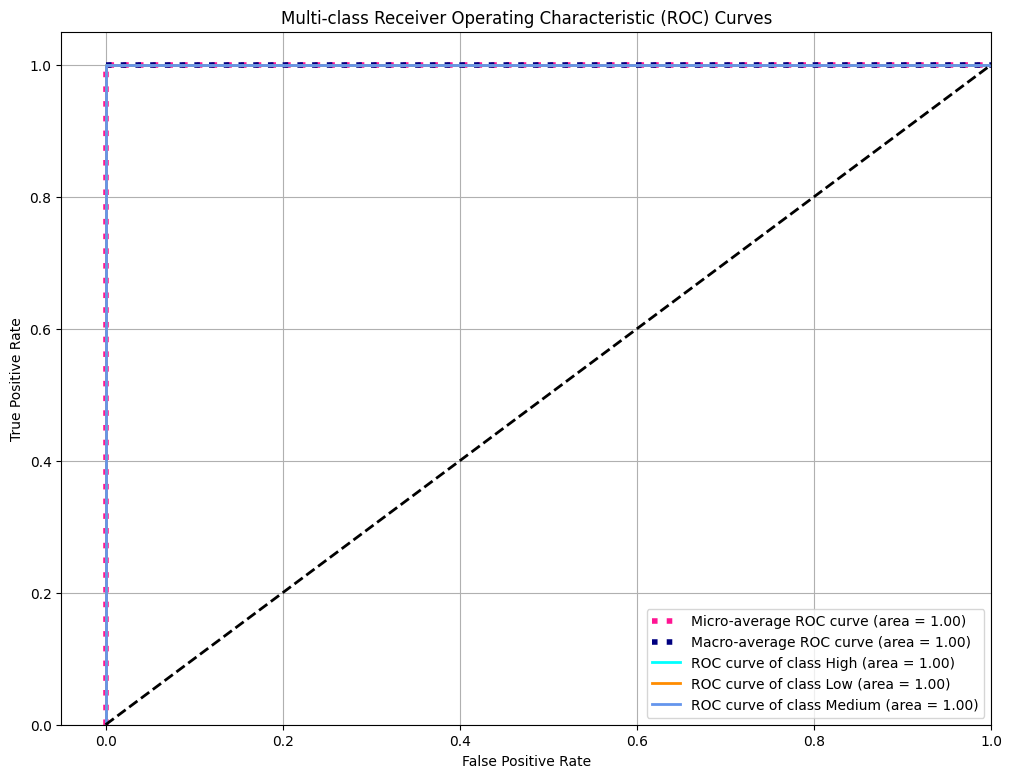


Skor AUC (One-vs-Rest):
AUC for class High: 1.0000
AUC for class Low: 1.0000
AUC for class Medium: 1.0000
AUC Micro-average: 1.0000
AUC Macro-average: 1.0000
Scikit-learn roc_auc_score (OvR, macro, direct): 1.0000
Scikit-learn roc_auc_score (OvR, weighted, direct): 1.0000


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

if 'current_model' in locals() and current_model and \
   'current_preprocessor' in locals() and current_preprocessor and \
   'current_label_encoder' in locals() and current_label_encoder:
    
    print("\n--- Mengevaluasi Model Final dengan ROC AUC ---")
    
    # Gunakan seluruh all_data sebagai set evaluasi untuk demonstrasi ini
    # Idealnya, ini adalah test set yang terpisah
    X_eval = all_data.drop(columns=[incremental_model_trainer.TARGET_COLUMN], errors='ignore')
    y_eval_raw = all_data[incremental_model_trainer.TARGET_COLUMN]

    # Pastikan label encoder sudah ter-fit (seharusnya sudah dari pelatihan)
    if not hasattr(current_label_encoder, 'classes_'):
        print("LabelEncoder tidak valid atau belum di-fit. Memuat ulang...")
        if os.path.exists(incremental_model_trainer.LABEL_ENCODER_PATH):
            current_label_encoder = joblib.load(incremental_model_trainer.LABEL_ENCODER_PATH)
        else:
            print("File LabelEncoder tidak ditemukan. Evaluasi ROC dibatalkan.")
            current_label_encoder = None

    if current_label_encoder and hasattr(current_label_encoder, 'classes_'):
        y_eval_encoded = current_label_encoder.transform(y_eval_raw)
        n_classes = len(current_label_encoder.classes_)
        
        # Binarize the output for OvR ROC curve
        y_eval_binarized = label_binarize(y_eval_encoded, classes=list(range(n_classes)))

        # Preprocess features
        numeric_features_for_model = [col for col in incremental_model_trainer.ALL_NUMERIC_FEATURES if col in X_eval.columns]
        categorical_features_for_model = [col for col in incremental_model_trainer.CATEGORICAL_FEATURES if col in X_eval.columns]

        X_eval_processed_numeric = pd.DataFrame(current_preprocessor.transform(X_eval[numeric_features_for_model]), columns=numeric_features_for_model, index=X_eval.index)
        X_eval_final_for_model = pd.concat([X_eval_processed_numeric, X_eval[categorical_features_for_model].reset_index(drop=True)], axis=1)
        
        cat_feature_indices_eval = [X_eval_final_for_model.columns.get_loc(col) for col in categorical_features_for_model if col in X_eval_final_for_model.columns]

        # Get predicted probabilities
        # Argumen cat_features tidak diperlukan lagi jika model sudah tahu mana fitur kategorikal
        # dan inputnya adalah Pandas DataFrame dengan nama kolom yang benar.
        y_score_proba = current_model.predict_proba(X_eval_final_for_model)

        # Compute ROC curve and ROC area for each class (One-vs-Rest)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_eval_binarized[:, i], y_score_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_eval_binarized.ravel(), y_score_proba.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute macro-average ROC curve and ROC area
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure(figsize=(12, 9))
        
        plt.plot(fpr["micro"], tpr["micro"],
                 label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label=f'Macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'forestgreen', 'red', 'purple', 'brown'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'ROC curve of class {current_label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Multi-class Receiver Operating Characteristic (ROC) Curves')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

        print("\nSkor AUC (One-vs-Rest):")
        for i in range(n_classes):
            print(f"AUC for class {current_label_encoder.classes_[i]}: {roc_auc[i]:.4f}")
        print(f"AUC Micro-average: {roc_auc['micro']:.4f}")
        print(f"AUC Macro-average: {roc_auc['macro']:.4f}")
        
        # Alternative way to get OvR AUC scores directly using roc_auc_score
        if n_classes > 1: # roc_auc_score multi_class options are for > 2 classes
          try:
              auc_ovr_macro_direct = roc_auc_score(y_eval_binarized, y_score_proba, average="macro", multi_class="ovr")
              auc_ovr_weighted_direct = roc_auc_score(y_eval_binarized, y_score_proba, average="weighted", multi_class="ovr")
              print(f"Scikit-learn roc_auc_score (OvR, macro, direct): {auc_ovr_macro_direct:.4f}")
              print(f"Scikit-learn roc_auc_score (OvR, weighted, direct): {auc_ovr_weighted_direct:.4f}")
          except ValueError as e:
              # This can happen if y_true is not binarized or other shape mismatches for some averages
              print(f"Note: Could not calculate direct roc_auc_score for multi_class 'ovr': {e}")
              # Try with y_eval_encoded for 'ovo' if applicable
              try:
                  auc_ovo_macro_direct = roc_auc_score(y_eval_encoded, y_score_proba, average="macro", multi_class="ovo")
                  auc_ovo_weighted_direct = roc_auc_score(y_eval_encoded, y_score_proba, average="weighted", multi_class="ovo")
                  print(f"Scikit-learn roc_auc_score (OvO, macro, direct): {auc_ovo_macro_direct:.4f}")
                  print(f"Scikit-learn roc_auc_score (OvO, weighted, direct): {auc_ovo_weighted_direct:.4f}")
              except Exception as e_ovo:
                  print(f"Error calculating roc_auc_score directly with 'ovo': {e_ovo}")      
else:
    print("\nModel, preprocessor, atau label encoder tidak sepenuhnya tersedia. Evaluasi ROC AUC dilewati.")


## 9. Kesimpulan

Notebook ini telah mendemonstrasikan:
1. Pemuatan dataset gabungan dari berbagai sektor.
2. Pelatihan model klasifikasi risiko kredit awal (`SGDClassifier`) pada subset data.
3. Pembaruan model secara inkremental menggunakan `partial_fit` ketika:
    - Data dari sektor baru ditambahkan.
    - Data historis baru untuk sektor yang sudah ada ditambahkan.
4. Penggunaan model yang telah dilatih/diperbarui untuk melakukan prediksi pada data baru.

Pendekatan ini memungkinkan model untuk beradaptasi dengan informasi baru dan pola dari berbagai sektor tanpa perlu melatih ulang keseluruhan model dari awal setiap kali ada data baru, yang penting untuk skenario di mana data datang secara bertahap dan beragam.